___
## EPHYS analysis
___

In [1]:
# Load modules and data
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

#Import all needed libraries
from matplotlib.lines import Line2D
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from statannot import add_stat_annotation
import itertools
from scipy import stats
from datahandler import Utils
from ast import literal_eval
from glob import glob
from open_ephys.analysis import Session
import pyopenephys
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

In [2]:
def ApplyChannelMap(Data, ChannelMap):
    print('Retrieving channels according to ChannelMap... ', end='')
    for R, Rec in Data.items():
        if Rec.shape[1] < len(ChannelMap) or max(ChannelMap) > Rec.shape[1]-1:
            print('')
            print('Not enough channels in data to apply channel map. Skipping...')
            continue

        Data[R] = Data[R][:,ChannelMap]

    return(Data)

def BitsToVolts(Data, ChInfo, Unit):
    print('Converting to uV... ', end='')
    Data = {R: Rec.astype('float32') for R, Rec in Data.items()}

    if Unit.lower() == 'uv': U = 1
    elif Unit.lower() == 'mv': U = 10**-3

    for R in Data.keys():
        for C in range(len(ChInfo)):
            Data[R][:,C] = Data[R][:,C] * ChInfo[C]['bit_volts'] * U
            if 'ADC' in ChInfo[C]['channel_name']: Data[R][:,C] *= 10**6

    return(Data)

def Load(Folder, Processor=None, Experiment=None, Recording=None, Unit='uV', ChannelMap=[]):
    Files = sorted(glob(Folder+'/**/*.dat', recursive=True))
    InfoFiles = sorted(glob(Folder+'/*/*/structure.oebin'))

    Data, Rate = {}, {}
    for F,File in enumerate(Files):
        File = File.replace('\\', '/') # Replace windows file delims
        Exp, Rec, _, Proc = File.split('/')[-5:-1]
        Exp = str(int(Exp[10:])-1)
        Rec = str(int(Rec[9:])-1)
        Proc = Proc.split('.')[0].split('-')[-1]
        if '_' in Proc: Proc = Proc.split('_')[0]

        if Proc not in Data.keys(): Data[Proc], Rate[Proc] = {}, {}

        if Experiment:
            if int(Exp) != Experiment-1: continue

        if Recording:
            if int(Rec) != Recording-1: continue

        if Processor:
            if Proc != Processor: continue

        print('Loading recording', int(Rec)+1, '...')
        if Exp not in Data[Proc]: Data[Proc][Exp] = {}
        Data[Proc][Exp][Rec] = np.memmap(File, dtype='int16', mode='c')


        Info = literal_eval(open(InfoFiles[F]).read())
        ProcIndex = [Info['continuous'].index(_) for _ in Info['continuous']
                     if str(_['source_processor_id']) == Proc][0] # Changed to source_processor_id from recorded_processor_id

        ChNo = Info['continuous'][ProcIndex]['num_channels']
        if Data[Proc][Exp][Rec].shape[0]%ChNo:
            print('Rec', Rec, 'is broken')
            del(Data[Proc][Exp][Rec])
            continue

        SamplesPerCh = Data[Proc][Exp][Rec].shape[0]//ChNo
        Data[Proc][Exp][Rec] = Data[Proc][Exp][Rec].reshape((SamplesPerCh, ChNo))
        Rate[Proc][Exp] = Info['continuous'][ProcIndex]['sample_rate']

    for Proc in Data.keys():
        for Exp in Data[Proc].keys():
            if Unit.lower() in ['uv', 'mv']:
                ChInfo = Info['continuous'][ProcIndex]['channels']
                Data[Proc][Exp] = BitsToVolts(Data[Proc][Exp], ChInfo, Unit)

            if ChannelMap: Data[Proc][Exp] = ApplyChannelMap(Data[Proc][Exp], ChannelMap)

    print('Done.')

    return(Data, Rate)

In [3]:
# Importing the data from a session
path = 'C:/Users/Tiffany/Documents/Ephys/E10_2021-06-13_12-31-21/'
os.getcwd() 
os.chdir(path)

In [4]:
# Load spike sorted data
spike_times= np.load('spike_times.npy') # Times of the spikes, array of lists
spike_clusters= np.load('spike_clusters.npy') # cluster number of each of the spikes, same length as before
df_labels = pd.read_csv("cluster_group.tsv",sep='\t') # Cluster labels (good, noise, mua) for the previous two arrays

In [5]:
# Transforms array of lists into array of ints
spike_times_df = [item for sublist in spike_times for item in sublist]

In [6]:
# Put the data in a single dataframe, one colum spikes, one colum clusters
s1 = pd.Series(spike_times_df, name='times')
s2 = pd.Series(spike_clusters, name='cluster_id')
df_temp = pd.concat([s1, s2], axis=1)

In [7]:
# Merge with cluster labels, use cluster ID to associate each one
df = pd.merge(df_temp,df_labels, on=['cluster_id'])

In [8]:
df

,times,cluster_id,group
0,7165,1193,good
1,11170,1193,good
2,18558,1193,good
3,29010,1193,good
4,41760,1193,good
5,46497,1193,good
6,67490,1193,good
7,72408,1193,good
8,73355,1193,good
9,76159,1193,good


In [9]:
# sns.scatterplot('fixed_times',np.repeat(1,len(df[df['cluster_id']==22][:1000])), data = df[df['cluster_id']==22][:1000],s=30,color='black')

In [10]:
# Select only clusters labelled good, which are presumably single units
df = df.loc[df.group == 'good']

In [ ]:
# Transform the values per session to seconds. This takes into account the framerate of the recordings, 30000Hz for virtually all the sessions. 
df['fixed_times'] = (df.times/30000)
print(min(df['fixed_times']),max(df['fixed_times']))

In [ ]:
df

C:\Users\Tiffany\Anaconda3\envs\envr\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


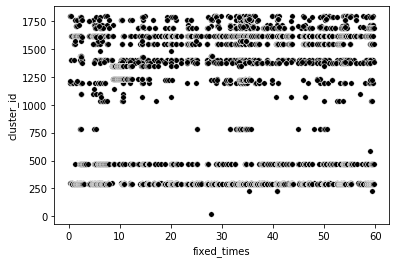

In [13]:
# Plot the first minute to have an impression of how it looks like
sns.scatterplot('fixed_times','cluster_id', data = df.loc[(df['fixed_times']<60)&(df.group=='good')],s=30,color='black')

In [14]:
len(df.loc[df.group == 'good'].cluster_id.unique())

54

In [15]:
os.getcwd() 
os.chdir(path)
df.to_csv(path+'spike.csv')

In [16]:
batch = 'general'

path2 = 'C:/Users/Tiffany/Google Drive/WORKING_MEMORY/EXPERIMENTS/ELECTROPHYSIOLOGY/EphysB/globals'
os.getcwd() 
os.chdir(path2)

df_trials = pd.read_csv(path2 + '/global_trials.csv', sep=';')
df_params = pd.read_csv(path2 + '/global_params.csv', sep=';')
df_behavior = pd.merge(df_params,df_trials, on=['session','subject_name'])

#Rename some of the variables for a global consensus.
df_behavior = df_behavior.rename(columns={'subject_name': 'subject','hithistory': 'hit', 'probabilities': 'prob', 'validhistory': 'valids'})

# #Remove those sessions that the animal wasn't in the final training step: STAGE 3 or above, MOTOR 6, no delay progression (delay lengths remain the same), good accuracy in short trials. 
df_behavior =  df_behavior.loc[(df_behavior['stage_number'] >= 3)&(df_behavior['motor'] == 6)&(df_behavior['delay_progression']==0)&(df_behavior['accuracy_low'] >= 0.60)&(df_behavior['accuracy'] >= 0.60)]

C:\Users\Tiffany\Anaconda3\envs\envr\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (0,1,5,6,7,8,9,10,27,28,37,38,47,48,55,56,57,59,60,61,65,66,67,72,73) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
# df = df.loc[(df['drug']=='Ephys')|(df['drug']=='EPHYS')]

In [18]:
df_behavior['hit']= df_behavior['hit'].astype(float)

In [19]:
# df.groupby(['subject','day']).count()

In [20]:
# sns.lineplot('delay_times','hit',data=df[df['subject']=='E13'],marker='o')

In [21]:
# fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,5))
# xaxis = [0,1,3,10]
# presented_delay = '0.1,1.0,3.0,10.0'

# sns.lineplot('delay_times','hit',hue='subject',data=df_behavior.loc[df_behavior['presented_delays']==presented_delay], marker='o', palette = 'GnBu_d', ax=ax[0], legend=False,err_style=None)
# plt.ylim(0.5,1)
# ax[0].set_ylabel('Accuracy')
# ax[1].set_xlabel('Delay times (s)')
# ax[0].set_xlabel('Delay times (s)')
# sns.despine()

# df_results = pd.DataFrame()
# df_results['accuracy'] = df_behavior.loc[df_behavior['presented_delays']==presented_delay].groupby(['subject','reward_side','delay_times'])['hit'].mean()
# df_results.reset_index(inplace=True)

# fit = np.polyfit(xaxis,np.array(df_results.groupby('delay_times')['accuracy'].mean()),1)
# fit_fn = np.poly1d(fit) 

# ax[1].errorbar(xaxis,np.array(df_results.groupby('delay_times')['accuracy'].mean()), fmt='o', markersize= 7, ecolor='grey',color='black', capsize=2)
# ax[1].plot(xaxis,np.array(df_results.groupby('delay_times')['accuracy'].mean()), 'ko', xaxis, fit_fn(xaxis), '--k')
# ax[1].errorbar(xaxis,np.array(df_results.groupby('delay_times')['accuracy'].mean()),yerr=np.array(df_results.groupby('delay_times')['accuracy'].sem()), fmt='o', markersize= 7, ecolor='grey',color='black', capsize=2)

# df_results = pd.DataFrame()
# df_results['accuracy'] =df.loc[df['presented_delays']==presented_delay].groupby(['subject','delay_times'])['hit'].mean()
# df_results.reset_index(inplace=True)
# # sns.lineplot(x='delay_times',y='accuracy', data=df_results, ci='sd', marker='o',ax=ax[1], err_style="bars",alpha=0.6,color='red')

# #Print the slopes
# slope, intercept, r_value, p_value, std_err = stats.linregress((xaxis,np.array(df_results.groupby('delay_times')['accuracy'].mean())))
# print('Slope:'+str(round(slope,3))+' Intercept:'+ str(round(intercept,3))+ ' R_value:'+ str(round(r_value,3)) + ' P_value:'+ str(round(p_value,3)) + ' Std_err:'+ str(std_err))


___
### Recover the ttls of delays from the dat files.

In [ ]:
session = Session(path)

In [ ]:
df_behavior = df_behavior.loc[(df_behavior.day == '2021-06-13')&(df_behavior.subject == 'E10')]

#Because the first trial has no delay, we need to shift one on the behavioral data in order to fit with the ttl one. 
df_behavior.delay_times[1:]

vector_answer_dev = np.logical_not(np.logical_xor(df_behavior['reward_side'], df_behavior['hit'].astype(int)))
vector_answer = np.where(vector_answer_dev==False, 0, 1)
df_behavior['vector_answer'] = vector_answer

In [ ]:
try:
    samples = session.recordings[0].continuous[0].samples[:,-8]
    timestamps = session.recordings[0].continuous[0].timestamps

    # samples = session.recordings[0].continuous[0].samples[:,-7]

    # Put the data in a single dataframe
    s1 = pd.Series(samples, name='samples')
    s2 = pd.Series(timestamps, name='timestamps')
    df_ttl = pd.concat([s1, s2], axis=1)
    
except:
    # Way to recover the data with recording node (Gui >0.5)
    session.recordnodes[0].recordings[0].continuous[0].metadata
    samples_delay = session.recordnodes[0].recordings[0].continuous[0].samples[:,-8] # Delay channel. 
    timestamps = session.recordnodes[0].recordings[0].continuous[0].timestamps
    samples_sound = session.recordnodes[0].recordings[0].continuous[0].samples[:,-6] # Sound node 

    # Put the data in a single dataframe
    s1 = pd.Series(samples_delay, name='samples')
    s2 = pd.Series(timestamps, name='timestamps')

    df_ttl = pd.concat([s1, s2], axis=1)

In [ ]:
# Transform the analog channel to boolean. 
df_ttl.loc[df_ttl['samples'] >=1000, 'ttl'] = 1
df_ttl.loc[df_ttl['samples'] <1000, 'ttl'] = 0

# Look for the places where there is a change and it goes from 0 to 1. 1 for on delay and -1 for off delay
df_ttl['diff'] = df_ttl.ttl.diff()
df_ttl['diff'].unique()

On is a 1 and -1 is an off of the delay period

In [ ]:
# Recover the first timestamp of the session. This is important because it is not 0 but when the recording was started. 
initial = df_ttl.timestamps.iloc[0]

In [ ]:
# Substract the first timestamp and divide by sampling frequency
df_ttl.timestamps = (df_ttl.timestamps - initial)/30000

In [ ]:
# Remove the rest of the values that does not have a change. 
df_ttl = df_ttl.loc[(df_ttl['diff'] == 1)|(df_ttl['diff'] == -1)]

In [ ]:
# Create a new colum with the delay duration
df_ttl['delay'] = np.around(df_ttl.loc[(df_ttl['diff'] == 1)|(df_ttl['diff'] == -1)]['timestamps'].diff(),2)

In [ ]:
# Check that we recover all the delays that were used. 
df_ttl.delay.unique()

In [ ]:
# Save the data in a new csv. 
os.getcwd() 
os.chdir(path)
df_ttl.to_csv(path+'timestamps.csv')

In [ ]:
# Remove all the colums which don't show the right delay lengths. 
df_ttl = df_ttl.loc[(df_ttl['delay'] == 1) | (df_ttl['delay'] == 10)| (df_ttl['delay'] == 3.00)| (df_ttl['delay'] == 0.1)]

np.array_equal(df.delay_times,df_ttl.delay)

In [ ]:
# file = pyopenephys.File('C:/Users/Tiffany/Documents/Ephys/E11_2021-05-14_14-27-21') 
# # experiment 1 (0 in Python)
# experiment = file.experiments[0]
# # recording 1 
# recording = experiment.recordings[0]

# print('Duration: ', recording.duration)
# print('Sampling Rate: ', recording.sample_rate)

# analog_signals = recording.analog_signals
# events_data = recording.events
# spiketrains = recording.spiketrains

# # tracking_data are accessible only using binary format
# tracking_data = recording.tracking

# # plot analog signal of channel 4
# signals = analog_signals[0]
# fig_an, ax_an = plt.subplots()
# ax_an.plot(signals.times, signals.signal[3])

# # plot raster for spike trains
# fig_sp, ax_sp = plt.subplots()
# for i_s, sp in enumerate(spiketrains):
#     ax_sp.plot(sp.times, i_s*np.ones(len(sp.times)), '|')

# plt.show()